<a href="https://colab.research.google.com/github/CeciSC/LSTMEquityIndexPrediction/blob/main/sp500_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add S&P 500 and HS300

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)


2.3.0


In [ ]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sp500.csv to sp500.csv


# New Section

In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['sp500.csv'].decode('utf-8')))
df

,Date,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1/4/10,1132.989990,1116.560059,1133.869995,1116.560059,3991400000,1115.100000,1115.100000,1126.420000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1670751798,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726
1,1/5/10,1136.520020,1132.660034,1136.630005,1129.660034,2491020000,1132.989990,1115.100000,1115.100000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1680495719,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499
2,1/6/10,1137.140015,1135.709961,1139.189941,1133.949951,4972660000,1136.520020,1132.989990,1115.100000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1689649585,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504
3,1/7/10,1141.689941,1136.270020,1142.459961,1131.319946,5270680000,1137.140015,1136.520020,1132.989990,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1700117112,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306
4,1/8/10,1144.979980,1140.520020,1145.390015,1136.219971,4389590000,1141.689941,1137.140015,1136.520020,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1708729171,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,12/23/19,3224.010010,3226.050049,3227.780029,3222.300049,3060610000,3221.219971,3205.370117,3191.139893,3206.852,3183.723,3156.2565,0.535042,1.265405,33.895614,3220.180785,3072.903061,94.586116,93.872407,3.418842,18.895714,55.21,106.58,3.707346,10.258503,1.802058,0.945974,87.681299,77.928883,75.000000,2825748610,0.000866,-0.000632,0.312038,0.002035,0.001805,0.017864,0.021466
2511,12/24/19,3223.379883,3225.449951,3226.429932,3220.510010,1296540000,3224.010010,3221.219971,3205.370117,3213.024,3192.809,3160.7435,0.322313,0.957495,34.643268,3229.009425,3071.991344,94.748524,94.586116,2.462563,17.448571,31.93,77.47,4.652638,12.008734,1.841543,1.022514,86.612135,77.532657,75.000000,2824040676,-0.000195,-0.000642,0.484782,0.001925,0.001422,0.017986,0.019817
2512,12/26/19,3239.909912,3227.199951,3240.080078,3227.199951,2160680000,3223.379883,3224.010010,3221.219971,3222.778,3202.637,3165.7130,0.531591,1.163822,36.152876,3239.808064,3070.260398,96.431209,94.748524,3.428230,17.520714,48.77,107.39,0.203422,0.706861,1.941590,1.149095,90.326191,80.387020,83.333333,2827207304,0.005128,0.003938,0.986788,0.003036,0.001572,0.019627,0.023438
2513,12/27/19,3240.020020,3247.229980,3247.929932,3234.370117,2428670000,3239.909912,3223.379883,3224.010010,3229.708,3209.782,3170.0325,0.319286,0.942058,36.932393,3249.230816,3070.056107,93.520236,96.431209,3.131814,16.120000,34.65,98.39,12.301711,28.847557,2.046353,1.281760,90.347574,80.405092,83.333333,2830565850,0.000034,-0.002220,0.416665,0.002150,0.001364,0.020215,0.022078


In [ ]:
df.dtypes

Date                              object
Close                            float64
Open                             float64
High                             float64
Low                              float64
Volume                             int64
x(t-1)                           float64
x(t-2)                           float64
x(t-3)                           float64
MA5                              float64
MA10                             float64
MA20                             float64
BIAS5                            float64
BIAS10                           float64
DIFF                             float64
BU                               float64
BL                               float64
KDJ                              float64
KDJ(t-1)                         float64
ROC                              float64
TR（14）                           float64
MTM6                             float64
MTM12                            float64
WR%10                            float64
WR%5            

In [ ]:
df[['Volume']] = df[['Volume']].astype('float')
df[['OBV']] = df[['OBV']].astype('float')

# df_feature = df[['Close','Open','High','Low','Volume']]
# df_feature.columns = [['close','open','high','low','volume']]
# df_feature.head()
df_feature = df
df_feature = df_feature.drop(['Date'], axis=1)
df_feature.head()

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1132.989990,1116.560059,1133.869995,1116.560059,3.991400e+09,1115.100000,1115.100000,1126.42000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1.670752e+09,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726
1,1136.520020,1132.660034,1136.630005,1129.660034,2.491020e+09,1132.989990,1115.100000,1115.10000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1.680496e+09,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499
2,1137.140015,1135.709961,1139.189941,1133.949951,4.972660e+09,1136.520020,1132.989990,1115.10000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1.689650e+09,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504
3,1141.689941,1136.270020,1142.459961,1131.319946,5.270680e+09,1137.140015,1136.520020,1132.98999,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1.700117e+09,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306
4,1144.979980,1140.520020,1145.390015,1136.219971,4.389590e+09,1141.689941,1137.140015,1136.52002,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1.708729e+09,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007


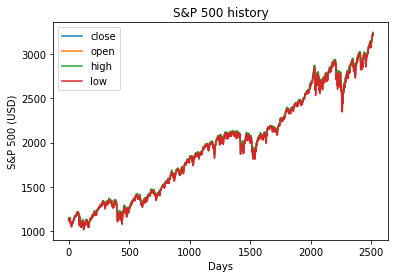

In [ ]:
### EDA
plt.figure()
plt.plot(df_feature[["Close"]])
plt.plot(df_feature[["Open"]])
plt.plot(df_feature[["High"]])
plt.plot(df_feature[["Low"]])
plt.title('S&P 500 history')
plt.ylabel('S&P 500 (USD)')
plt.xlabel('Days')
plt.legend(['close', 'open','high','low'], loc='upper left')
plt.show()

In [ ]:
data_train = df_feature.iloc[:2013, :]
data_test = df_feature.iloc[2013:, :]
print(data_train.shape, data_test.shape)

(2013, 37) (502, 37)


In [ ]:
# 一阶差分
scaler = MinMaxScaler(feature_range = (0,1))
train = scaler.fit_transform(data_train)
test = scaler.transform(data_test)

In [ ]:
y_train = np.array(df_feature.iloc[:2013, 0])
y_test = np.array(df_feature.iloc[2013:, 0])
print(y_train.shape, y_test.shape)

(2013,) (502,)


In [ ]:
past_steps = 15
next_steps = 1

In [ ]:
X_train = np.array([train[i : i + past_steps, :] for i in range(0, train.shape[0] - (next_steps+ past_steps),1)])
X_test = np.array([test[i : i + past_steps, :] for i in range(0, test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
y_train_regression = np.array([y_train[i + past_steps + next_steps] for i in range(0,train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression = np.array([y_test[i + past_steps + next_steps] for i in range(0,test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
INPUT_DIM = data_train.shape[1]
output_dim = 1
batch_size = 8 #每轮训练模型时，样本的数量
epochs = 2000 #训练60轮次
hidden_size = 128
lstm_units = 64

In [ ]:
def LSTM_fun_keras_att(n_input,train_x,train_y,predict_x,prediction_y,seq_len=5):
    tf.compat.v1.keras.backend.get_session().close()
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session())
    tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())
    inputs = Input(shape=(seq_len, n_input))
    #drop1 = Dropout(0.3)(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    #x = Conv1D(filters=128, kernel_size=5, activation='relu')(output1)#embedded_sequences
    x = MaxPooling1D(pool_size = past_steps)(x)
    x = Dropout(0.1)(x)
    print(x.shape)
    lstm_out = Bidirectional(LSTM(32, activation='relu'), name='bilstm')(x)
    #lstm_out = LSTM(lstm_units,activation='relu')(x)
    print(lstm_out.shape)
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(lstm_out)
    #attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
    attention_mul =Multiply()([lstm_out, attention_probs])
    #attention_mul = merge([lstm_out, attention_probs],output_shape=32, name='attention_mul', mode='mul')
    output = Dense(1, activation='linear')(attention_mul)
    #output = Dense(10, activation='sigmoid')(drop2)

    model = Model(inputs=inputs, outputs=output)
    print(model.summary())
    model.compile(loss='mse', optimizer='adam')
    #model_class.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    # fit model
    history = model.fit(train_x, train_y,validation_split=0.1, epochs=epochs, batch_size=1, shuffle=False, verbose=2, callbacks=[es])
    #history = model.fit(train_x, train_y, epochs=100, batch_size=1, shuffle=False)
    y_pred = model.predict(predict_x)
    return y_pred

In [ ]:
y_pred_regression = LSTM_fun_keras_att(INPUT_DIM, X_train, y_train_regression, X_test, y_test_regression,seq_len=past_steps)

(None, 1, 32)
(None, 64)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 37)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15, 32)       1216        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1, 32)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1, 32)        0           max_pooling1d[0][0]              
______________________________________________________________

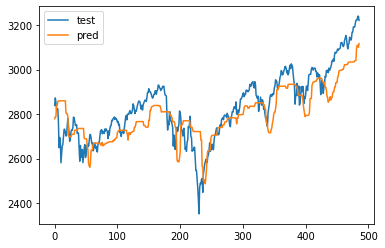

In [ ]:
# plot training history
plt.plot(y_test_regression, label='test')
plt.plot(y_pred_regression, label='pred')
plt.legend()
plt.show()

In [ ]:
import numpy as np
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / true)

In [ ]:
print(MAPE(y_test_regression,y_pred_regression))

0.053839655033216985


In [ ]:
##### HS300

from google.colab import files
uploaded = files.upload()

Saving hs300.csv to hs300 (1).csv


In [ ]:
import pandas as pd
import io

hs = pd.read_csv(io.StringIO(uploaded['hs300.csv'].decode('utf-8')))
hs

,date,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1/4/10,3535.2290,3592.4680,3597.7480,3535.2290,6610108000,3575.6840,3575.6800,3558.8570,3529.79,3455.11850,3508.973800,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.4120,-25.4940,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,15761101790,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,1/5/10,3564.0380,3545.1860,3577.5260,3497.6610,8580964100,3535.2290,3575.6840,3575.6840,3546.91,3471.86010,3503.734100,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.2550,83.8850,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,15846911431,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,1/6/10,3541.7270,3558.7000,3588.8320,3541.1730,7847312500,3564.0380,3535.2290,3575.6840,3555.11,3495.47850,3499.619500,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.2940,149.9920,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,15768438306,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,1/7/10,3471.4560,3543.1600,3558.5560,3452.7690,8035003700,3541.7270,3564.0380,3535.2290,3537.63,3508.97610,3495.468400,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.2810,74.8340,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,15688088269,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,1/8/10,3480.1300,3456.9080,3482.0830,3426.6980,6079025300,3471.4560,3541.7270,3564.0380,3518.52,3513.10740,3490.613050,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.7270,174.5870,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,15748878522,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,12/25/19,3990.8671,3988.6574,4000.5556,3976.3559,9493889000,3992.9581,3967.0962,4017.2527,3999.06,3991.66975,3931.248280,-0.2050,-0.0201,29.5162,4050.547309,3789.291191,59.0441,65.4477,2.4495,36.8824,-50.9325,95.4203,42.1334,67.250737,2.1166,1.426661,56.018210,58.590802,50.000000,41770235585,-0.0005,0.0006,0.5996,-0.002092,0.001468,0.018743,0.015165
2427,12/26/19,4025.9879,3993.6686,4025.9879,3993.5413,10886064000,3990.8671,3992.9581,3967.0962,3998.83,4005.16612,3939.432530,0.6791,0.5199,31.3967,4061.172471,3787.752475,60.6246,59.0441,3.2203,37.6992,-6.7947,125.6036,29.0058,24.967494,1.9755,1.571487,66.959028,63.912328,50.000000,41879096225,0.0088,0.0081,1.0000,-0.000058,0.002082,0.017191,0.021972
2428,12/27/19,4022.0278,4029.2454,4066.7964,4019.7223,15092641100,4025.9879,3990.8671,3992.9581,3999.79,4010.54679,3949.100390,0.5560,0.2863,32.1963,4070.493169,3788.618685,59.2181,60.6246,3.0563,39.1533,-5.1217,119.2786,39.6995,43.409408,1.8273,1.688829,64.778650,62.917741,50.000000,41728169814,-0.0010,-0.0018,0.0490,0.000239,0.002454,0.015321,0.018467
2429,12/30/19,4081.6334,4015.5195,4083.6901,4001.4951,15597148800,4022.0278,4025.9879,3990.8671,4022.69,4019.95549,3961.379115,1.4652,1.5343,37.2108,4087.226847,3789.703361,72.2409,59.2181,4.8987,43.6764,64.3807,190.6092,1.7136,1.713563,1.8678,1.855955,77.822341,70.464660,50.000000,41884141302,0.0148,0.0165,0.9750,0.005727,0.003109,0.018635,0.030357


In [ ]:
hs.dtypes

date                              object
close                            float64
open                             float64
high                             float64
low                              float64
volume                             int64
x(t-1)                           float64
x(t-2)                           float64
x(t-3)                           float64
MA5                              float64
MA10                             float64
MA20                             float64
BIAS5                            float64
BIAS10                           float64
DIFF                             float64
BU                               float64
BL                               float64
KDJ                              float64
KDJ(t-1)                         float64
ROC                              float64
TR（14）                           float64
MTM6                             float64
MTM12                            float64
WR%10                            float64
WR%5            

In [ ]:
hs[['volume']] = hs[['volume']].astype('float')
hs[['OBV']] = hs[['OBV']].astype('float')
hs_feature = hs
hs_feature = hs_feature.drop(['date'], axis=1)
hs_feature.head()

,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,3535.229,3592.468,3597.748,3535.229,6.610108e+09,3575.684,3575.680,3558.857,3529.79,3455.1185,3508.97380,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.412,-25.494,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,1.576110e+10,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,3564.038,3545.186,3577.526,3497.661,8.580964e+09,3535.229,3575.684,3575.684,3546.91,3471.8601,3503.73410,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.255,83.885,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,1.584691e+10,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,3541.727,3558.700,3588.832,3541.173,7.847312e+09,3564.038,3535.229,3575.684,3555.11,3495.4785,3499.61950,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.294,149.992,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,1.576844e+10,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,3471.456,3543.160,3558.556,3452.769,8.035004e+09,3541.727,3564.038,3535.229,3537.63,3508.9761,3495.46840,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.281,74.834,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,1.568809e+10,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,3480.130,3456.908,3482.083,3426.698,6.079025e+09,3471.456,3541.727,3564.038,3518.52,3513.1074,3490.61305,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.727,174.587,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,1.574888e+10,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003


In [ ]:
hs.iloc[:1944,:]

,date,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1/4/10,3535.2290,3592.4680,3597.7480,3535.2290,6.610108e+09,3575.6840,3575.6800,3558.8570,3529.79,3455.11850,3508.973800,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.4120,-25.4940,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,1.576110e+10,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,1/5/10,3564.0380,3545.1860,3577.5260,3497.6610,8.580964e+09,3535.2290,3575.6840,3575.6840,3546.91,3471.86010,3503.734100,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.2550,83.8850,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,1.584691e+10,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,1/6/10,3541.7270,3558.7000,3588.8320,3541.1730,7.847312e+09,3564.0380,3535.2290,3575.6840,3555.11,3495.47850,3499.619500,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.2940,149.9920,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,1.576844e+10,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,1/7/10,3471.4560,3543.1600,3558.5560,3452.7690,8.035004e+09,3541.7270,3564.0380,3535.2290,3537.63,3508.97610,3495.468400,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.2810,74.8340,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,1.568809e+10,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,1/8/10,3480.1300,3456.9080,3482.0830,3426.6980,6.079025e+09,3471.4560,3541.7270,3564.0380,3518.52,3513.10740,3490.613050,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.7270,174.5870,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,1.574888e+10,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,12/25/17,4041.5401,4057.4173,4086.9342,4026.4496,9.192696e+09,4054.5984,4067.8485,4030.4898,4045.96,4028.82140,4026.040530,-0.1093,0.3157,-0.0612,4177.429244,3927.683033,67.2614,69.9653,1.7749,52.4560,60.6843,70.4832,38.1463,44.895357,-0.4140,-0.557433,52.305887,50.817007,50.000000,3.909811e+10,-0.0032,-0.0039,0.2495,0.002788,-0.000104,0.004843,0.003850
1940,12/26/17,4053.6224,4040.6173,4056.8554,4015.2996,9.111879e+09,4041.5401,4054.5984,4067.8485,4049.62,4032.58201,4025.930475,0.0988,0.5218,1.3843,4168.516541,3929.656429,68.8432,67.2614,1.2550,50.0413,68.3310,50.2432,27.9931,46.086141,-0.0457,-0.367066,56.427674,52.678053,50.000000,3.918923e+10,0.0030,0.0032,0.9222,0.000904,-0.000027,0.005857,0.006878
1941,12/27/17,3991.2075,4045.2793,4047.7366,3986.7385,1.051536e+10,4053.6224,4041.5401,4054.5984,4041.76,4026.69349,4022.803205,-1.2508,-0.8813,-2.4779,4140.880740,3939.869614,52.4146,68.8432,-1.9239,50.3936,-44.1219,-78.2922,80.4427,95.539729,-0.0121,-0.313364,36.743384,43.419306,50.000000,3.908408e+10,-0.0154,-0.0134,0.0733,-0.001940,-0.000777,0.003932,-0.007854
1942,12/28/17,4018.8974,3992.9970,4036.6975,3980.2358,1.185429e+10,3991.2075,4053.6224,4041.5401,4031.97,4025.96807,4023.443110,-0.3243,-0.1756,-3.2667,4099.608793,3965.090084,49.2184,52.4146,0.0717,50.2338,-11.5924,2.8811,57.1738,63.765530,0.1388,-0.108135,46.650982,47.854955,50.000000,3.920262e+10,0.0069,0.0065,0.6847,-0.002422,0.000159,0.002279,-0.001130


In [ ]:
hs_train = hs_feature.iloc[:1944, :]
hs_test = hs_feature.iloc[1944:, :]
print(hs_train.shape, hs_test.shape)

(1944, 37) (487, 37)


In [ ]:
# 一阶差分
scaler = MinMaxScaler(feature_range = (0,1))
hs_train = scaler.fit_transform(hs_train)
hs_test = scaler.transform(hs_test)

In [ ]:
y_train_hs = np.array(hs_feature.iloc[:1944, 0])
y_test_hs = np.array(hs_feature.iloc[1944:, 0])
print(y_train_hs.shape, y_test_hs.shape)

(1944,) (487,)


In [ ]:
past_steps = 10
next_steps = 3

In [ ]:
X_train_hs = np.array([hs_train[i : i + past_steps, :] for i in range(0, hs_train.shape[0] - (next_steps+ past_steps),1)])
X_test_hs = np.array([hs_test[i : i + past_steps, :] for i in range(0, hs_test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
y_train_regression_hs = np.array([y_train_hs[i + past_steps + next_steps] for i in range(0, hs_train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression_hs = np.array([y_test_hs[i + past_steps + next_steps] for i in range(0, hs_test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
def LSTM_fun_keras_att(n_input,train_x,train_y,predict_x,prediction_y,seq_len=5):
    tf.compat.v1.keras.backend.get_session().close()
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session())
    tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())
    inputs = Input(shape=(seq_len, n_input))
    #drop1 = Dropout(0.3)(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    #x = Conv1D(filters=128, kernel_size=5, activation='relu')(output1)#embedded_sequences
    x = MaxPooling1D(pool_size = past_steps)(x)
    x = Dropout(0.1)(x)
    print(x.shape)
    lstm_out = Bidirectional(LSTM(32, activation='relu'), name='bilstm')(x)
    #lstm_out = LSTM(lstm_units,activation='relu')(x)
    print(lstm_out.shape)
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(lstm_out)
    #attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
    attention_mul =Multiply()([lstm_out, attention_probs])
    #attention_mul = merge([lstm_out, attention_probs],output_shape=32, name='attention_mul', mode='mul')
    output = Dense(1, activation='linear')(attention_mul)
    #output = Dense(10, activation='sigmoid')(drop2)

    model = Model(inputs=inputs, outputs=output)
    print(model.summary())
    model.compile(loss='mse', optimizer='adam')
    #model_class.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    # fit model
    history = model.fit(train_x, train_y,validation_split=0.1, epochs=epochs, batch_size=1, shuffle=False, verbose=2, callbacks=[es])
    #history = model.fit(train_x, train_y, epochs=100, batch_size=1, shuffle=False)
    y_pred = model.predict(predict_x)
    return y_pred

In [ ]:
y_pred_regression_hs = LSTM_fun_keras_att(INPUT_DIM, X_train_hs, y_train_regression_hs, X_test_hs, y_test_regression_hs, seq_len=past_steps)

(None, 1, 32)
(None, 64)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 37)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 32)       1216        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1, 32)        0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 32)        0           max_pooling1d_1[0][0]            
______________________________________________________________

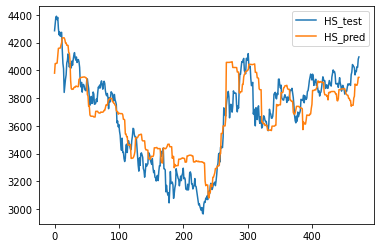

In [ ]:
# plot training history
plt.plot(y_test_regression_hs, label='HS_test')
plt.plot(y_pred_regression_hs, label='HS_pred')
plt.legend()
plt.show()

In [ ]:
print(MAPE(y_test_regression_hs,y_pred_regression_hs))

0.09355762578929477
